# **Explainable AI for Skin Disease Classification Using LIME, SHAP, and PDP**

## INTRODUCTION
Early and accurate detection of skin diseases, particularly skin cancer, is crucial for effective treatment. This notebook leverages deep learning and machine learning techniques to classify various types of skin diseases, with a strong emphasis on explainability and model interpretability.

We employ a Convolutional Neural Network (CNN) to predict skin cancer types directly from dermoscopic images. The CNN model automates the feature extraction process, improving accuracy while minimizing the need for manual intervention. To make the model's decisions transparent, we integrate LIME (Local Interpretable Model-Agnostic Explanations), providing visual and localized explanations of the CNN's predictions—an essential step in medical AI applications where trust and interpretability are critical.

In parallel, we use structured clinical data (CSV) with a Gradient Boosting (XGBoost) model to perform skin disease classification. To understand how individual features influence the model’s decisions, we incorporate Partial Dependence Plots (PDPs) and SHAP (SHapley Additive exPlanations) values, offering both global and local interpretability.

Ultimately, this notebook aims not only to achieve high predictive performance but also to provide transparent, explainable insights into how and why predictions are made—ensuring the model can be understood and trusted by medical professionals.

## ABOUT THE DATASET

The HAM10000 ("Human Against Machine with 10,000 training images") dataset is a large collection of 10,015 dermatoscopic images representing seven common types of pigmented skin lesions. 

Labels are confirmed via histopathology, follow-up, expert consensus, or confocal microscopy. In addition to images, the dataset includes CSV files containing clinical metadata—such as patient demographics, lesion location, and diagnostic remarks—which can be used for structured-data modeling.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma


In [1]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [2]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [3]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [5]:
df.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

## **Data Cleaning**

### Removing NULL values and performing visualizations to gain insights of dataset: Univariate and Bivariate Analysis

In [6]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

The feature 'age' consists of 57 null records. Thus, we need to replace them with the mean of 'age' since dropping 57 records would lead to loss of data.

In [7]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [8]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [9]:
#Create a dictionary mapping image IDs to file paths

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [10]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
1  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
2  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
3  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
4  ../input/skin-cancer-mnist-ham10000/ham10000_i...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [11]:
df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [12]:
class_names= df['cell_type'].unique().tolist()
class_names

['Benign keratosis-like lesions ',
 'Melanocytic nevi',
 'Dermatofibroma',
 'Melanoma',
 'Vascular lesions',
 'Basal cell carcinoma',
 'Actinic keratoses']

## **Image Preprocessing**

### Resizing of images because the original dimensions of 450 * 600 * 3 take long time to process in Neural Networks

In [13]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

### Showcasing some samples of each class of the dataset in the images below:

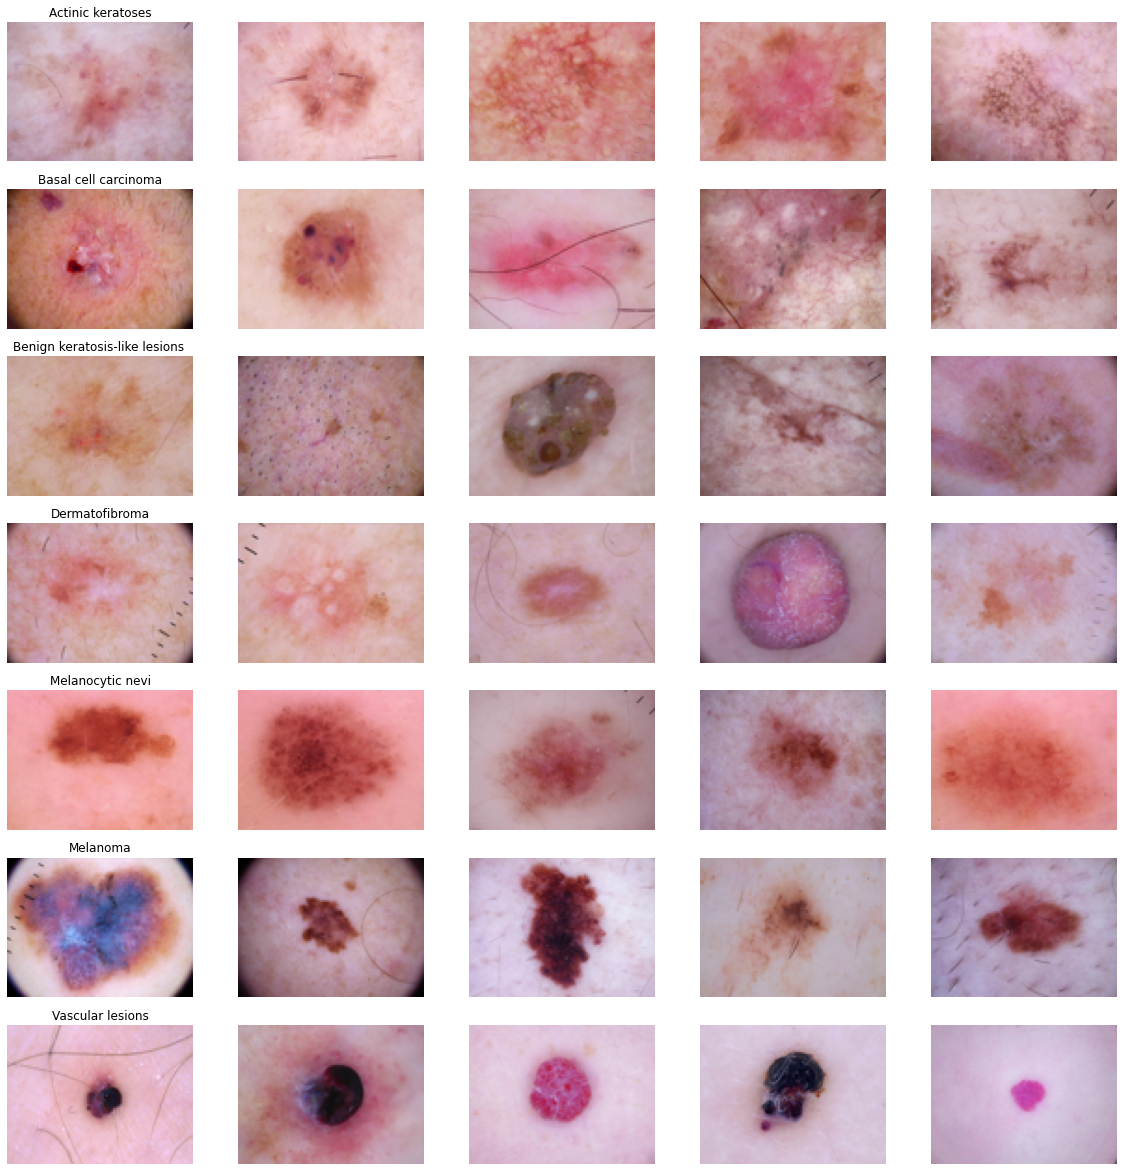

In [14]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [15]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

## **Exploratory Data Analysis**

Exploratory data analysis can help detect obvious errors, identify outliers in datasets, understand relationships, unearth important factors, find patterns within data, and provide new insights.

In [16]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

### UNIVARIATE ANALYSIS

<AxesSubplot:title={'center':'CELL TYPE'}, ylabel='Count'>

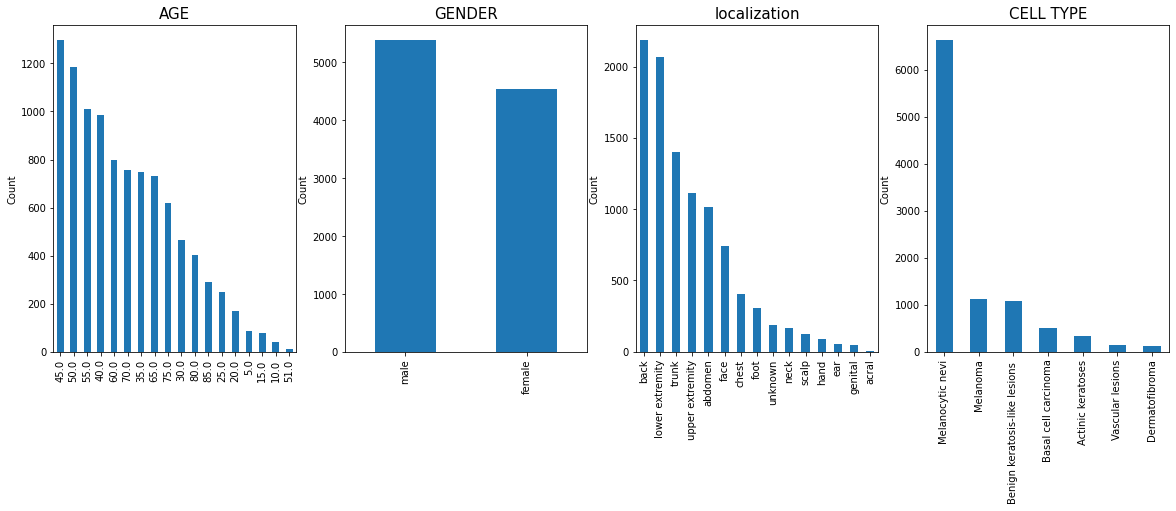

In [17]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

1. Skin diseases are found to be maximum in people aged around 45. Minimum for 10 and below. We also observe that the probability of having skin disease increases with the increase in age.
2. Skin diseases are more prominent in Men as compared to Women and other gender.
3. Skin diseases are more visible on the "back" of the body and least on the "acral surfaces"(such as limbs, fingers, or ears).
4. The most found disease among people is Melanocytic nevi while the least found is Dermatofibroma.

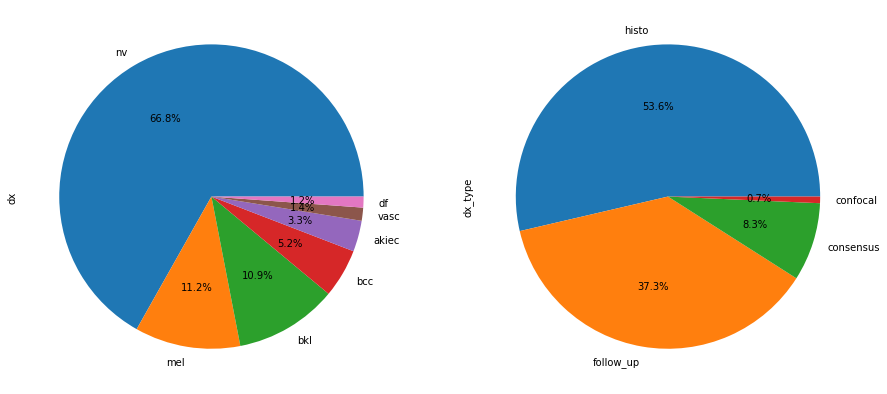

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

1.  Type of skin disease:
    *     nv: Melanocytic nevi - 69.9%
    *     mel: Melanoma - 11.1 %
    *     bkl: Benign keratosis-like lesions - 11.0%
    *     bcc: Basal cell carcinoma - 5.1%
    *     akiec: Actinic keratoses- 3.3%
    *     vasc: Vascular lesions-1.4%
    *     df: Dermatofibroma - 1.1%

2. How the skin disease was discovered:
   * histo - histopathology - 53.3%
   * follow_up - follow up examination - 37.0%
   * consensus - expert consensus - 9.0%
   * confocal - confirmation by in-vivo confocal microscopy - 0.7%

### BIVARIATE ANALYSIS

<AxesSubplot:title={'center':'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

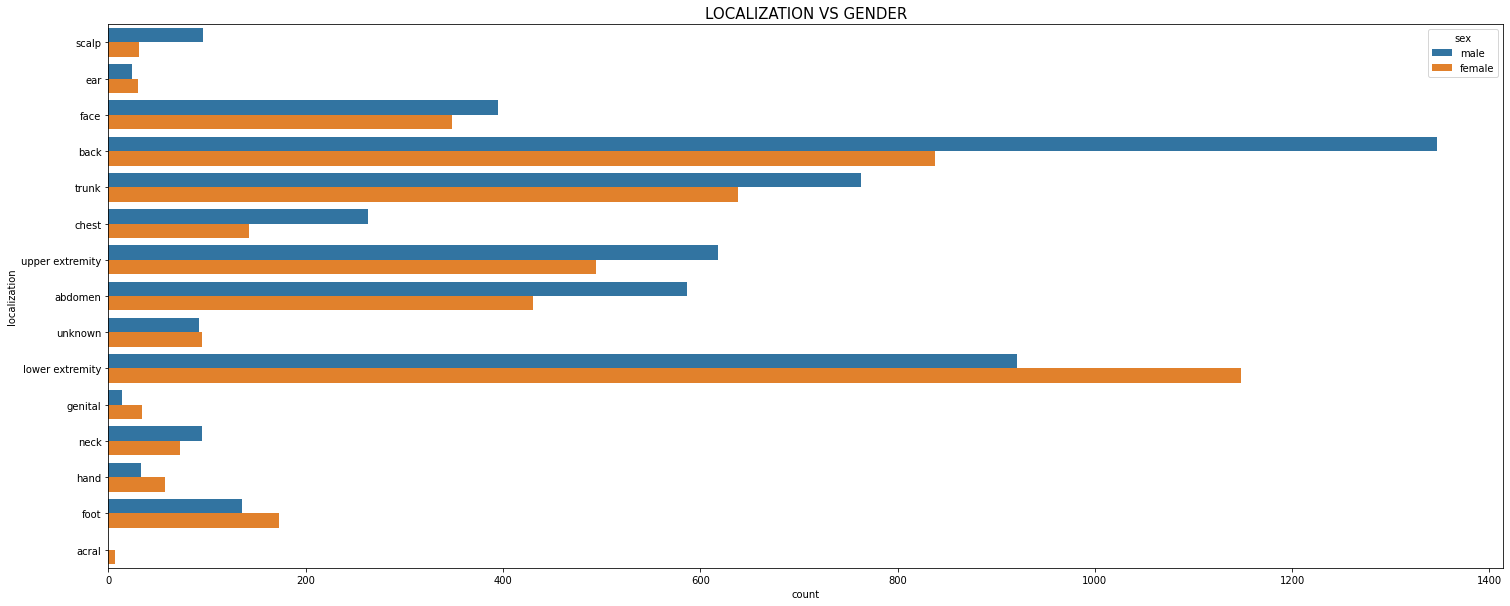

In [19]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)

* Back are is the most affected among people and more prominent in men.
* Infection on Lower extremity of the body is more visible in women.
* Some unknown regions also show infections and it's visible in men, women and other genders.
* The acral surfaces show the least infection cases that too in men only. Other gender groups don't show this kind of infection.


<AxesSubplot:title={'center':'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

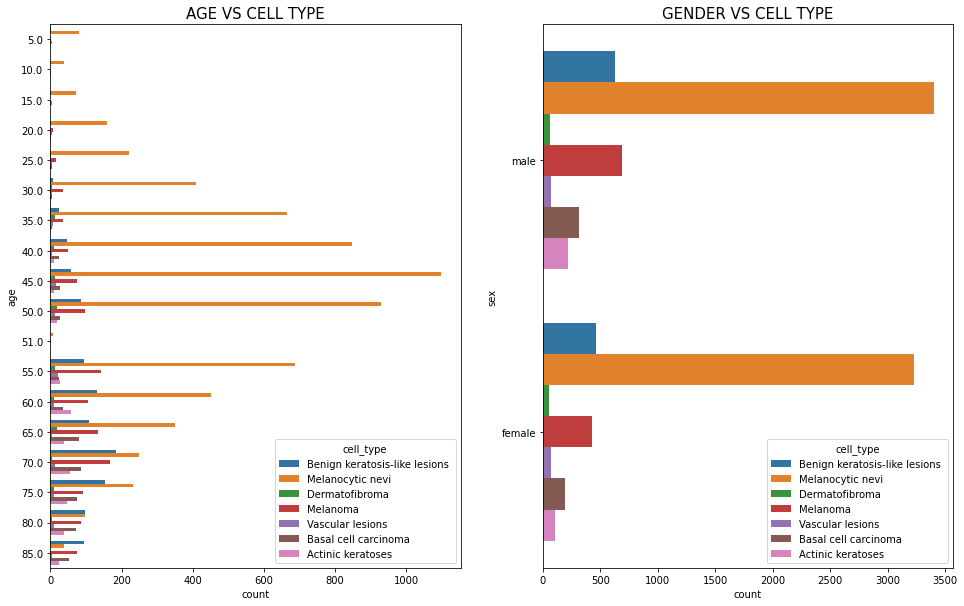

In [20]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)

1. The age group between 0-75 years is infected the most by Melanocytic nevi. On the other hand, the people aged 80-90 are affected more by Benign keratosis-like lesions.

2. All the gender groups are affected the most by Melanocytic nevi.

## **CNN**

I built a convolutional neural network (CNN) using the Keras Sequential API, which allows stacking layers one at a time in a straightforward, linear fashion.

🔹 Convolutional Blocks
The core of the network consists of three convolutional blocks, each composed of:

   - Two Conv2D layers followed by ReLU activation

   - A MaxPooling2D layer for downsampling

   - A Dropout layer for regularization

In the first block, I used 32 filters for both convolutional layers. In the second and third blocks, I increased the number of filters to 64, allowing the network to learn more abstract and complex patterns. Each Conv2D layer applies learnable filters (kernels) to the input image, producing feature maps that highlight important local patterns like edges, textures, or shapes.

🔹 Pooling and Downsampling
After each pair of convolutional layers, a MaxPooling2D layer is used. This layer reduces the spatial dimensions of the feature maps by selecting the maximum value in non-overlapping windows. Pooling not only reduces computational cost, but also improves translational invariance and helps prevent overfitting.

🔹 Regularization with Dropout
To further combat overfitting, I included a Dropout layer after each pooling layer and again before the final output. Dropout randomly disables a fraction of the neurons during training, encouraging the model to learn more robust and generalized patterns.

🔹 Activation Functions
All convolutional layers use the ReLU (Rectified Linear Unit) activation function, defined as f(x) = max(0, x). This non-linear activation introduces essential complexity into the network and accelerates convergence during training.

🔹 Transition to Fully Connected Layers
After the convolutional blocks, a Flatten layer converts the final 2D feature maps into a 1D vector, preparing the data for the dense (fully connected) layers. This step connects local features learned by the convolutional layers into a global representation of the image.

🔹 Final Dense Layers
   - The final part of the model consists of:

   - Two Dense (fully connected) layers to combine and interpret the extracted features.

   - A final Dense output layer with softmax activation, producing a probability distribution over the target classes.

This final output allows the model to predict the most likely skin disease class for a given input image.



![Skin Disease Cover](https://i.ibb.co/K7zKQk8/cover.png)


In [21]:
from keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense*2 -> Dropout -> Out
input_shape = (100, 75, 3)
num_classes = 7

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
cnn_model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.16))

cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
cnn_model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.20))

cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 75, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 75, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 37, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 18, 32)        0

In [23]:
# Define the optimizer
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [24]:
# Compile the model
cnn_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
df = df.reset_index(drop=True)  # Add this before train_test_split
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=667)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Actinic keratoses', b'Melanocytic nevi', b'Dermatofibroma',
       b'Basal cell carcinoma', b'Melanoma',
       b'Benign keratosis-like lesions ', b'Vascular lesions'],
      dtype=object)>, idx=<tf.Tensor: shape=(7440,), dtype=int32, numpy=array([0, 0, 1, ..., 1, 1, 5], dtype=int32)>)

In [28]:
print(x_train_o.shape)
print(x_test_o.shape)

(7440, 10)
(2481, 10)


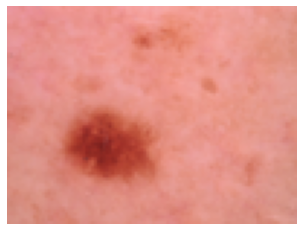

In [29]:
import matplotlib.pyplot as plt
images = x_train_o['image']
images_label = x_test_o['image']
# Display the first image in x_train
plt.imshow(images.iloc[10])
plt.axis('off')  # Hide axes
plt.show()


In [30]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())


x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

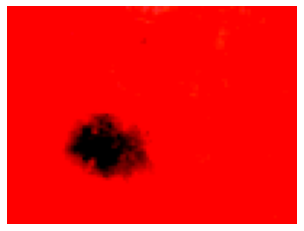

In [31]:
import matplotlib.pyplot as plt

# Display the first image in x_train
plt.imshow(x_train[10])
plt.axis('off')  # Hide axes
plt.show()


In [32]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

### Applied Data augmentation using ImageDatagenerator before model training

Since the data is less, we apply data augmentation using ImageDataGenerator.

ImageDataGenerator generates augmentation of images in real-time while the model is still training. One can apply any random transformations on each training image as it is passed to the model.

#### The CNN model is a repeated network of the following layers:

1. Convolutional
1. Pooling
1. Dropout
1. Flatten
1. Dense

Optimizer: Adam

Activation function used: Softmax



In [33]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 75, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 75, 3))
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [34]:
# Fit the model
epochs = 50
batch_size = 16
history = cnn_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
418/418 [==============================] - 16s 32ms/step - loss: 1.1420 - accuracy: 0.6545 - val_loss: 1.0365 - val_accuracy: 0.6492
Epoch 2/50
418/418 [==============================] - 12s 29ms/step - loss: 0.9897 - accuracy: 0.6620 - val_loss: 0.9945 - val_accuracy: 0.6505
Epoch 3/50
418/418 [==============================] - 12s 29ms/step - loss: 0.9459 - accuracy: 0.6559 - val_loss: 0.9604 - val_accuracy: 0.6371
Epoch 4/50
418/418 [==============================] - 12s 30ms/step - loss: 0.9017 - accuracy: 0.6628 - val_loss: 0.9337 - val_accuracy: 0.6546
Epoch 5/50
418/418 [==============================] - 12s 29ms/step - loss: 0.8851 - accuracy: 0.6715 - val_loss: 0.9172 - val_accuracy: 0.6680
Epoch 6/50
418/418 [==============================] - 13s 30ms/step - loss: 0.8207 - accuracy: 0.6963 - val_loss: 0.8922 - val_accuracy: 0.6640
Epoch 7/50
418/418 [==============================] - 12s 30ms/step - loss: 0.8123 - accuracy: 0.6928 - val_loss: 0.9158 - val_accuracy:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



418/418 [==============================] - 12s 30ms/step - loss: 0.6155 - accuracy: 0.7660 - val_loss: 0.7336 - val_accuracy: 0.7218
Epoch 41/50
418/418 [==============================] - 12s 29ms/step - loss: 0.6308 - accuracy: 0.7555 - val_loss: 0.7369 - val_accuracy: 0.7164
Epoch 42/50
418/418 [==============================] - 12s 30ms/step - loss: 0.6443 - accuracy: 0.7506 - val_loss: 0.7463 - val_accuracy: 0.7137
Epoch 43/50
418/418 [==============================] - 13s 30ms/step - loss: 0.6401 - accuracy: 0.7512 - val_loss: 0.7463 - val_accuracy: 0.7177
Epoch 44/50
418/418 [==============================] - 12s 29ms/step - loss: 0.6107 - accuracy: 0.7632 - val_loss: 0.7392 - val_accuracy: 0.7097
Epoch 45/50
418/418 [==============================] - 12s 30ms/step - loss: 0.6218 - accuracy: 0.7536 - val_loss: 0.7410 - val_accuracy: 0.7110


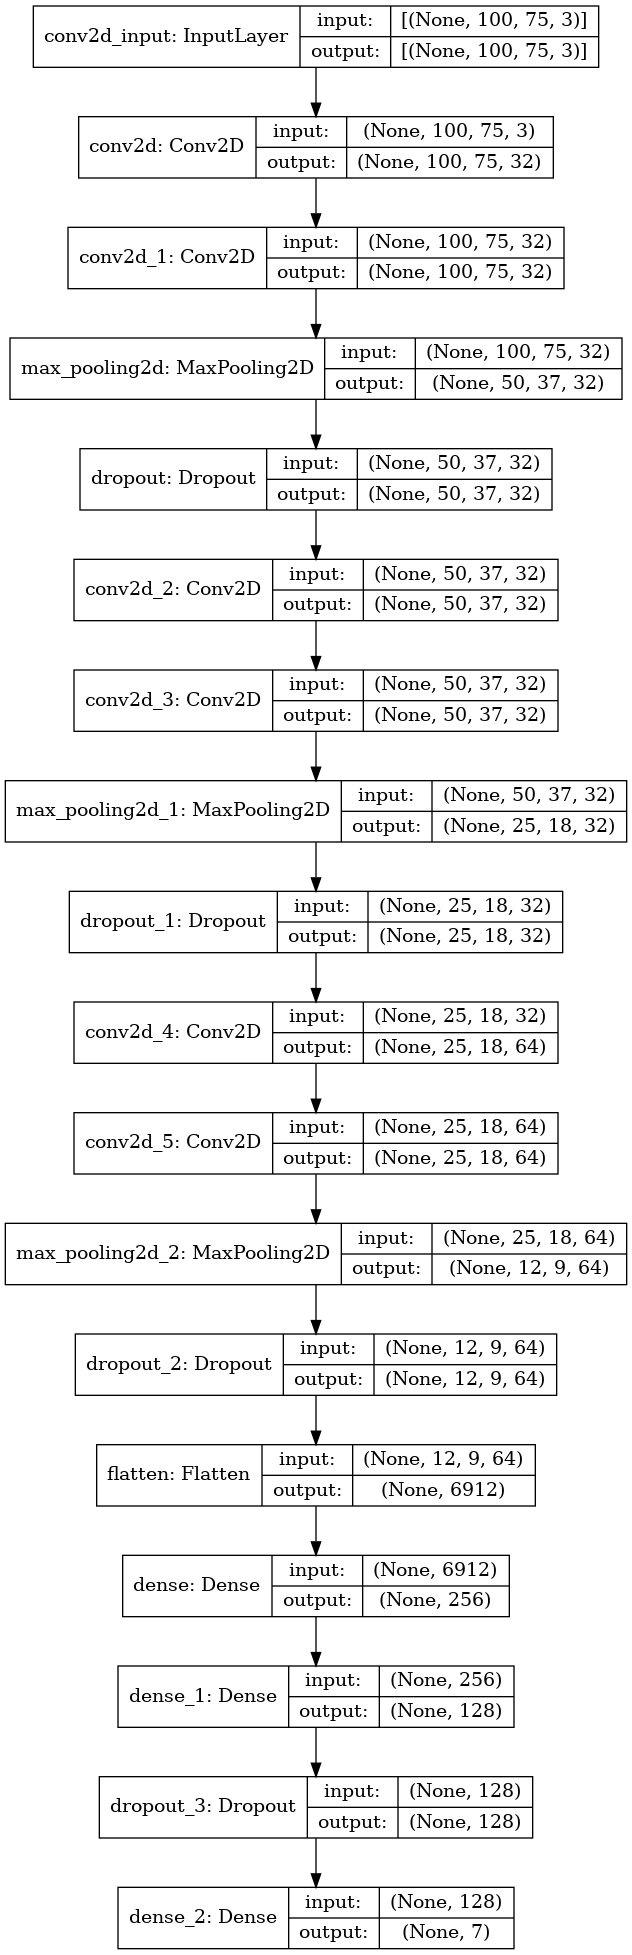

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

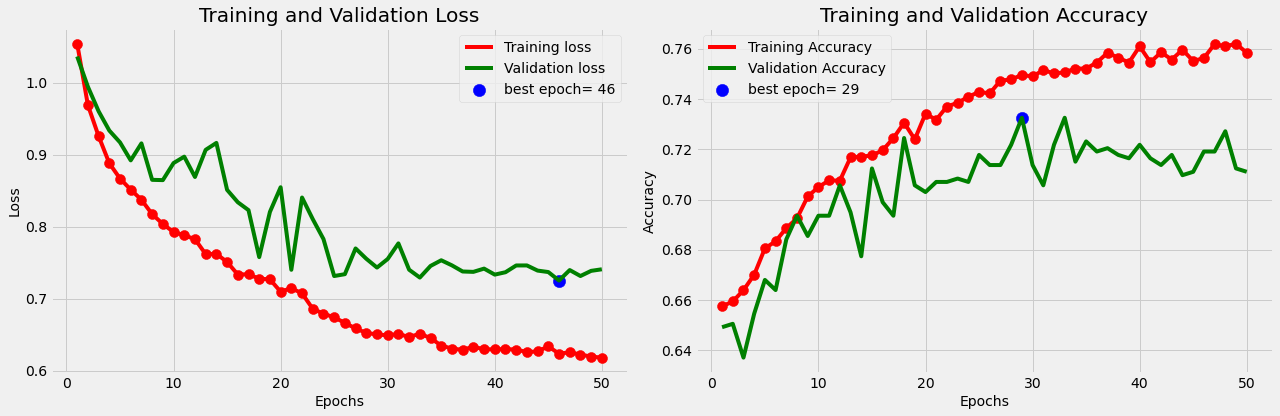

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def tr_plot(tr_data):
    start_epoch = 0
    # Récupération des données d'entraînement et de validation
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    # Nombre total d'époques
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))

    # Meilleures époques
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    # Étiquettes pour les meilleurs points
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    # Création des graphiques
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Courbe de Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend()

    # Courbe d'Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

tr_plot(history)

### Training and Validation Performance Analysis

The plots show how the model performs over 50 epochs in terms of loss and accuracy.

#### Loss (Left Plot):
- **Training loss** (red): Smoothly decreases → model is learning well on training data.
- **Validation loss** (green): Decreases initially, but fluctuates and plateaus after **epoch 32**.
- **Best validation loss** at **epoch 32** → model generalizes best here.

#### Accuracy (Right Plot):
- **Training accuracy** (red): Steady increase, reaching ~0.76.
- **Validation accuracy** (green): Peaks at **epoch 24**, then stagnates or slightly decreases.

####  Conclusion:
- The model starts **overfitting** after **epoch 24–32**.
- Consider using **early stopping**, **dropout**, or **data augmentation** to improve generalization.


In [37]:
loss, accuracy = cnn_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = cnn_model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


24/24 [==============================] - 0s 4ms/step - loss: 0.7410 - accuracy: 0.7110
Validation: accuracy = 0.711021  ;  loss_v = 0.740971
Test: accuracy = 0.735994  ;  loss = 0.720016


### confusion matrix for validation dataset

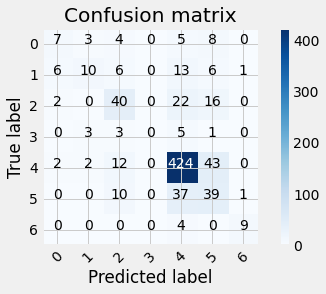

In [38]:
import itertools
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


### confusion matrix for validation dataset

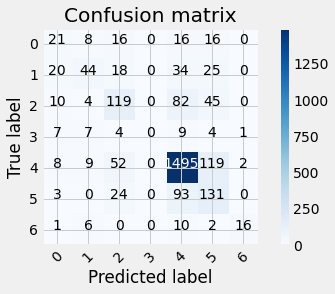

In [39]:
# Predict the values from the validation dataset
Y_pred = cnn_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

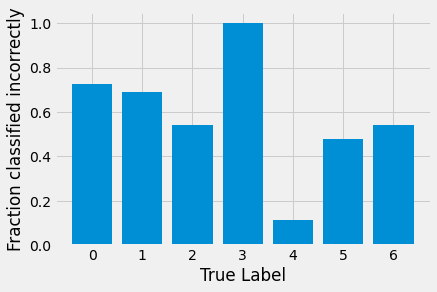

In [40]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Analysis of Misclassification by Class

The bar chart shows the fraction of misclassified samples for each true label (classes 0 to 6). The y-axis represents the proportion of incorrectly classified instances in each class.

#### Observations:
- **Class 3**: Highest error rate (**100%** misclassified). This may indicate the class is underrepresented or easily confused with others.
- **Classes 0, 1, 2**: High misclassification rates (**60–70%**), suggesting notable confusion among these classes.
- **Class 4**: Lowest error rate (around **10%**), indicating the model performs well on this class.
- **Classes 5 and 6**: Moderate error rates (**30–50%**), which might be acceptable depending on the dataset complexity.


### Saving our custom cnn model


In [41]:
cnn_model.save("model.h5")

# Why not using Transfer learning (Resnet50) instead?

## ResNet50:
ResNet50 is a deep convolutional neural network with 50 layers, introduced by Microsoft Research in the 2015 paper “Deep Residual Learning for Image Recognition”. It belongs to the family of Residual Networks (ResNets).

## Key Ideas:
Very deep architecture (50 layers) designed to learn complex features.

Uses residual blocks with skip connections: instead of learning a full mapping, it learns the residual (difference) between input and output of a block.

This makes training deeper networks easier, helping to avoid problems like vanishing gradients.

In [42]:
#import model layers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
#build the model
def build_model(backbone):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.7))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(7, activation='softmax',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.001)))
    model.compile(loss='sparse_categorical_crossentropy',optimizer="Adagrad",metrics=['accuracy'])
    return model

from keras import layers
from keras.models import Sequential
from keras.applications import ResNet50

resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(100,75,3))
resnet_model = build_model(resnet)
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 14343     
Total params: 23,610,247
Trainable params: 23,553,031
Non-trainable params: 57,216
_________________________________________________________________


In [43]:
resnet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Example: Train your model with validation
history = resnet_model.fit(
    x_train, y_train,
    epochs=25,  # Or your desired number of epochs
    batch_size=32,  # Typical batch size for medical images
    validation_data=(x_validate, y_validate),
    verbose=1
)


Epoch 1/25
210/210 [==============================] - 18s 64ms/step - loss: 4.0532 - accuracy: 0.5290 - val_loss: 2.0898 - val_accuracy: 0.6492
Epoch 2/25
210/210 [==============================] - 12s 58ms/step - loss: 1.3202 - accuracy: 0.6680 - val_loss: 1.4966 - val_accuracy: 0.6492
Epoch 3/25
210/210 [==============================] - 12s 58ms/step - loss: 1.1487 - accuracy: 0.6828 - val_loss: 1.4621 - val_accuracy: 0.6519
Epoch 4/25
210/210 [==============================] - 12s 58ms/step - loss: 1.1219 - accuracy: 0.7031 - val_loss: 1.1918 - val_accuracy: 0.6626
Epoch 5/25
210/210 [==============================] - 12s 58ms/step - loss: 1.0767 - accuracy: 0.7093 - val_loss: 1.2927 - val_accuracy: 0.6694
Epoch 6/25
210/210 [==============================] - 12s 58ms/step - loss: 1.0419 - accuracy: 0.7279 - val_loss: 1.2084 - val_accuracy: 0.6909
Epoch 7/25
210/210 [==============================] - 12s 58ms/step - loss: 1.0206 - accuracy: 0.7312 - val_loss: 3.5997 - val_accuracy:

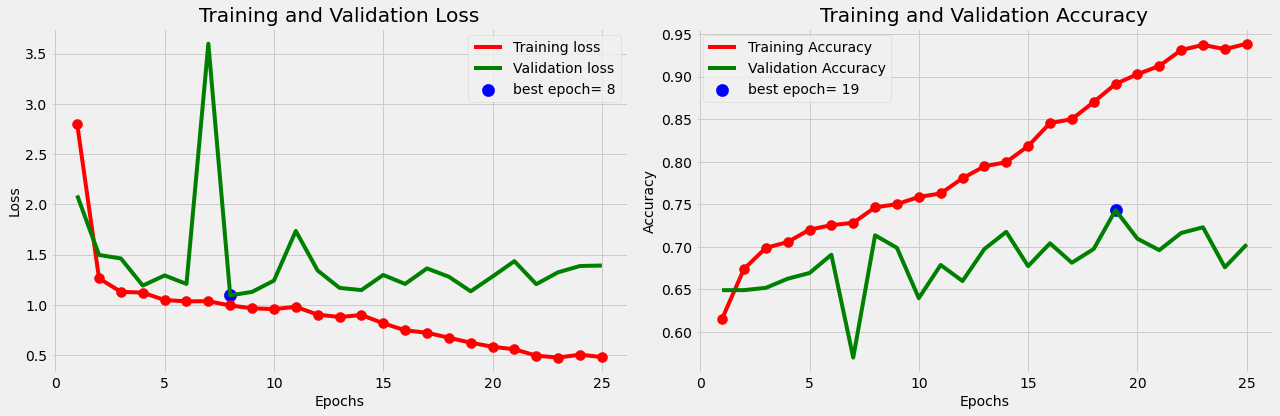

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def tr_plot(tr_data):
    start_epoch = 0
    # Récupération des données d'entraînement et de validation
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    # Nombre total d'époques
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))

    # Meilleures époques
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    # Étiquettes pour les meilleurs points
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    # Création des graphiques
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Courbe de Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend()

    # Courbe d'Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

tr_plot(history)

-  **severe overfitting**
-  **The model might be too complex for our dataset size**


 ***We decide to continue with our custom CNN model for the XAI part***

## **XAI**

### Interpretation of results of model using Feature Importance techniques

The increasing trend in the use of machine learning for critical applications such as medical diagnosis suggests an imperative need for methodologies that can help to understand and evaluate the predictions of machine-learning models. 

There are two main ways to look at a classification or a regression model: 
1. inspect model parameters and try to figure out how the model works globally; 
2. inspect an individual prediction of a model, try to figure out why the model makes the decision it makes. 

For example, LIME, or Local Interpretable Model-Agnostic Explanations, is an algorithm that can explain the predictions of any classifier or regressor in a faithful way, by approximating it locally with an interpretable model.-


### Techniques applied: LIME, PDP, SHAP, etc.

## **LIME**

### LIME is a technique that explains how the input features of a machine learning model affect its predictions. For instance, for image classification tasks, LIME finds the region of an image (set of super-pixels) with the strongest association with a prediction label.


### LIME creates explanations by generating a new dataset of random perturbations (with their respective predictions) around the instance being explained and then fitting a weighted local surrogate model -  model that gives explanation of individual predictions.

Step 1: Generate random perturbations for input image

Step 2: Predict class for perturbations

Step 3: Compute weights (importance) for the perturbations

Step 4: Fit a explainable linear model using the perturbations, predictions and weights


![Frog](https://theblue.ai/wp-content/uploads/2019/04/figure4.jpg)


In [46]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Function to get LIME explanations
def get_lime_explanation(image, model, class_names):
    """Get LIME explanation for an image prediction"""
    # Create the LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Prepare the image
    img_processed = image.copy()
    
    # Get the explanation
    explanation = explainer.explain_instance(
        img_processed.astype('double'), 
        model.predict, 
        top_labels=5, 
        hide_color=0, 
        num_samples=1000
    )
    
    # Get the prediction and explanation
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_class = np.argmax(pred[0])
    
    # Get the explanation for the predicted class
    temp, mask = explanation.get_image_and_mask(
        pred_class,
        positive_only=True, 
        num_features=10, 
        hide_rest=False
    )
    
    # Generate the visualization
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"LIME Explanation\nPredicted: {class_names[pred_class]}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(range(len(class_names)), pred[0])
    plt.xticks(range(len(class_names)), [c[:5] for c in class_names], rotation=45)
    plt.title("Class Probabilities")
    
    plt.tight_layout()
    plt.show()
    
    return explanation

# Apply LIME to sample images
def analyze_with_lime(x_samples, y_true, num_images=3):
    """Analyze images with LIME"""
    for i in range(min(num_images, len(x_samples))):
        # Get the sample and denormalize it for display
        img = x_samples[i].copy()
        
        
        # Get the true class
        true_class = np.argmax(y_true[i])
        print(f"Analyzing image {i+1} (True class: {class_names[true_class]})")
        
        # Get LIME explanation
        explanation = get_lime_explanation(x_samples[i], cnn_model, class_names)

Analyzing image 1 (True class: Vascular lesions)


  0%|          | 0/1000 [00:00<?, ?it/s]

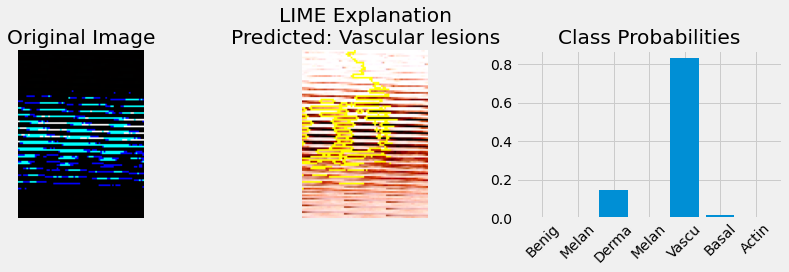

Analyzing image 2 (True class: Vascular lesions)


  0%|          | 0/1000 [00:00<?, ?it/s]

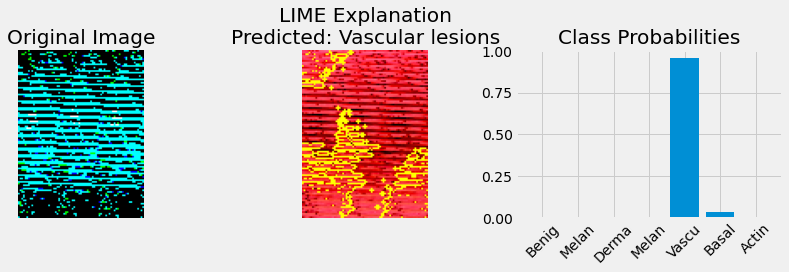

Analyzing image 3 (True class: Basal cell carcinoma)


  0%|          | 0/1000 [00:00<?, ?it/s]

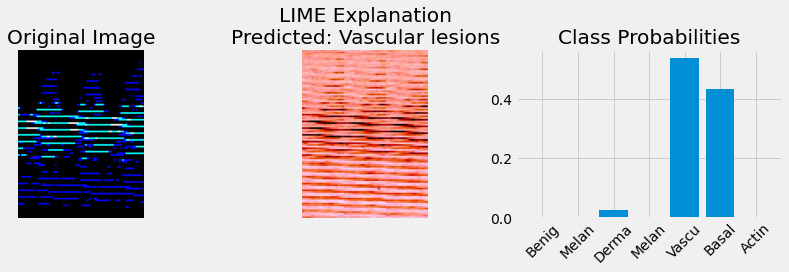

In [47]:
# Sample some validation images for LIME analysis
sample_idx = np.random.choice(range(len(x_validate)), size=3, replace=False)
analyze_with_lime(x_validate[sample_idx], y_validate[sample_idx])

In [48]:
import skimage.io 
import skimage.segmentation

In [49]:
np.random.seed(222)

Xi = x_test[3]
preds = cnn_model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes
top_pred_classes

array([1, 3, 4, 2, 6])

In [50]:
print(y_test[3])

[0. 0. 0. 0. 1. 0. 0.]


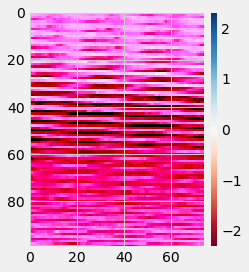

In [51]:
skimage.io.imshow(Xi)

Color Scale Analysis: The colorbar on the right (ranging from -2 to 2) indicates this is likely showing normalized pixel values

The number of super pixels generated


7

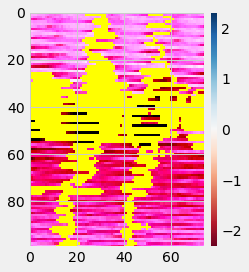

In [52]:
#Generate segmentation for image
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))
print("The number of super pixels generated")
num_superpixels

Why This Matters for Skin Cancer Classification
Superpixels help explainability tools like LIME by:

Breaking images into meaningful regions

Identifying which areas most influence your CNN's predictions

Making explanations more human-interpretable

In [53]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 

[1 1 1 1 0 0 1]


In [54]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = cnn_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 7)


This code generates perturbed versions of an image to analyze which superpixels (segments) most influence your CNN's predictions. This is the core mechanism behind LIME's explainability.

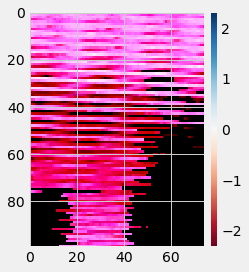

In [55]:
skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))

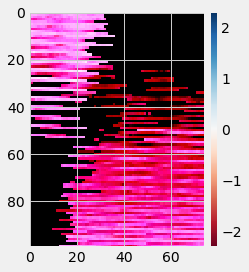

In [56]:
skimage.io.imshow(perturb_image(Xi,perturbations[11],superpixels))

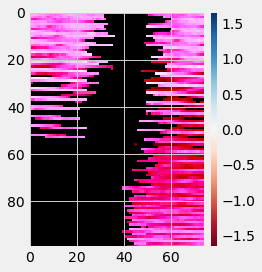

In [57]:
skimage.io.imshow(perturb_image(Xi,perturbations[2],superpixels))

In [58]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)
(150,)


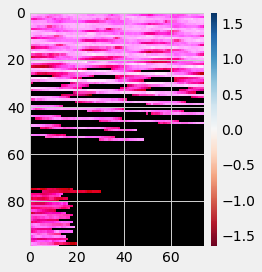

In [59]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = 4
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi,mask,superpixels))

This is what LIME returns as explanation. 
The area of the image (super-pixels) that has a stronger association with the prediction of the disease of class 4. This explanation suggests that the model is doing a good job predicting the class for the given image. 

This example shows how LIME can help to increase confidence in a machine-learning model by understanding why it is returning certain predictions.

# **Explaining tabular data**

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap  # Use this instead
from scipy.special import logit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Then use shap.KernelExplainer instead of KernelShap

In [61]:
tile_df = df.copy()

In [62]:
tile_df.drop('lesion_id', inplace=True, axis=1)
tile_df.drop('image_id', inplace=True, axis=1)
tile_df.drop('cell_type', inplace=True, axis=1)
tile_df.drop('path', inplace=True, axis=1)
tile_df.drop('dx', inplace=True, axis=1)
tile_df.head()

dx_type   age   sex localization  cell_type_idx  \
0   histo  80.0  male        scalp              2   
1   histo  80.0  male        scalp              2   
2   histo  80.0  male        scalp              2   
3   histo  80.0  male        scalp              2   
4   histo  75.0  male          ear              2   

                                               image  
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...  
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...  
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...  
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...  
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...

In [63]:
X = tile_df.drop(['cell_type_idx'],axis=1).values
y = tile_df['cell_type_idx'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [64]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


As the dataframe consisted of a few features in the form of strings, we have processed these features by localization one hot method. 

In [65]:
tile_df['localization_onehot'] = tile_df.localization.map({'scalp':0, 'ear':1, 'face':2, 'neck':3,'back':4, 'trunk':5, 'chest':6,
       'upper extremity':7, 'abdomen':8, 'lower extremity':9,
       'genital':10, 'hand':11, 'foot':12, 'acral':13, 'unknown':14})
tile_df.head()

dx_type   age   sex localization  cell_type_idx  \
0   histo  80.0  male        scalp              2   
1   histo  80.0  male        scalp              2   
2   histo  80.0  male        scalp              2   
3   histo  80.0  male        scalp              2   
4   histo  75.0  male          ear              2   

                                               image  localization_onehot  
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...                    0  
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...                    0  
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...                    0  
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...                    0  
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...                    1

In [66]:
tile_df['dx_type_onehot'] = tile_df.dx_type.map({'confocal':0,'consensus':1,'follow_up':2,'histo':3})
tile_df.head()

dx_type   age   sex localization  cell_type_idx  \
0   histo  80.0  male        scalp              2   
1   histo  80.0  male        scalp              2   
2   histo  80.0  male        scalp              2   
3   histo  80.0  male        scalp              2   
4   histo  75.0  male          ear              2   

                                               image  localization_onehot  \
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...                    0   
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...                    0   
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...                    0   
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...                    0   
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...                    1   

   dx_type_onehot  
0               3  
1               3  
2               3  
3               3  
4               3

In [67]:
tile_df['gender_male'] = tile_df.sex.map({'female':0, 'male':1, 'unknown':2})
tile_df.head()

dx_type   age   sex localization  cell_type_idx  \
0   histo  80.0  male        scalp              2   
1   histo  80.0  male        scalp              2   
2   histo  80.0  male        scalp              2   
3   histo  80.0  male        scalp              2   
4   histo  75.0  male          ear              2   

                                               image  localization_onehot  \
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...                    0   
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...                    0   
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...                    0   
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...                    0   
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...                    1   

   dx_type_onehot  gender_male  
0               3            1  
1               3            1  
2               3            1  
3               3            1  
4               3            1

In [68]:
tile_df.columns

Index(['dx_type', 'age', 'sex', 'localization', 'cell_type_idx', 'image',
       'localization_onehot', 'dx_type_onehot', 'gender_male'],
      dtype='object')

In [69]:
features = ['age',  'localization_onehot', 'dx_type_onehot','gender_male']

In [70]:
X = tile_df[features]
y = tile_df['cell_type_idx'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [71]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Creating a XGB Classifier model for the prediction of the type of skin disease using a tabular dataset:

In [72]:
xgb_model = XGBClassifier(random_state=1)
xgb_model = xgb_model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[00:28:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [73]:
y_pred = xgb_model.predict(X_test)

In [74]:
predictions = [round(value) for value in y_pred]

In [75]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.87%


# **Shap:**

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional theory.

![SHAP Header](https://raw.githubusercontent.com/shap/shap/master/docs/artwork/shap_header.svg)


In [76]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [77]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  [-0.6565658, -0.22117907, 0.45192364, -1.8466053, 2.6667223, 0.53093946, -1.2809393]


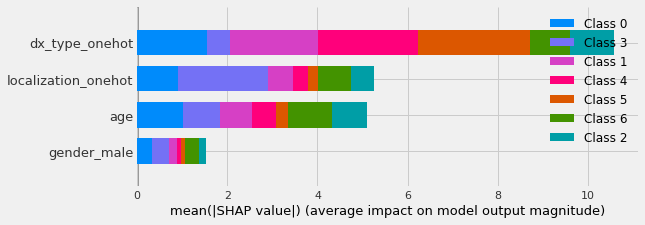

In [78]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The feature importance plot, other than showing us which features are the most important, also show us which feature plays a major role in the prediction of which class.
For example, we observe that the localization plays a major role in predicting whether the disease belongs to class 3. Similarly, dx_type_onehot plays a major role in predicting whether the disease belongs to class 1, 5, etc.

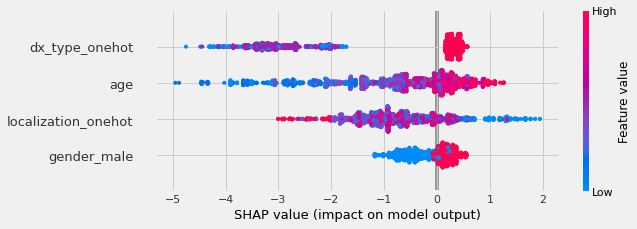

In [79]:
shap.summary_plot(shap_values[0], X_test)

From this summary plot, we observe the effect of the different values of each feature on the SHAP value, which is used for prediction. For example, we see that the higher values of dx_type_onehot (follow up and histopathology) are associated with a higher SHAP value.

In [80]:
from sklearn.preprocessing import LabelEncoder

## Preprocess training and test target (y) after having performed train-test split
le = LabelEncoder()
y_multi_train = pd.Series(le.fit_transform(y_train))
y_multi_test = pd.Series(le.transform(y_test))

## Check classes
le.classes_

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

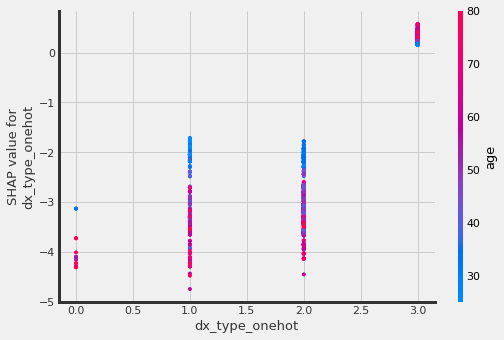

In [81]:
shap.initjs()
shap.dependence_plot('dx_type_onehot', interaction_index='age',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test)

In this graph, the effect of dx_type_onehot at specific ages is seen on the SHAP value. In congruence to what we observed in the earlier graph, the higher the value for dx_type_onehot (expert consensus or confirmation by microscopy) 

In [82]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], X_test.iloc[:100,:])

In [83]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][15,:], X_test.iloc[15,:])

Here, the force plot shows a local instance of the dataset. The localisation and type of diagnosis impact the prediction positively due to their positive SHAP value. 
On the other hand, the age and gender of the patient impacts the model negatively. 

# **PDP :**

A Partial Dependence Plot (PDP) is a visualization tool that helps interpret machine learning models by showing how the average predicted output changes as one or more features vary, while keeping all other features constant. It's a way to understand the relationship between specific features and the model's prediction .


In [84]:
from pdpbox import pdp, get_dataset, info_plots

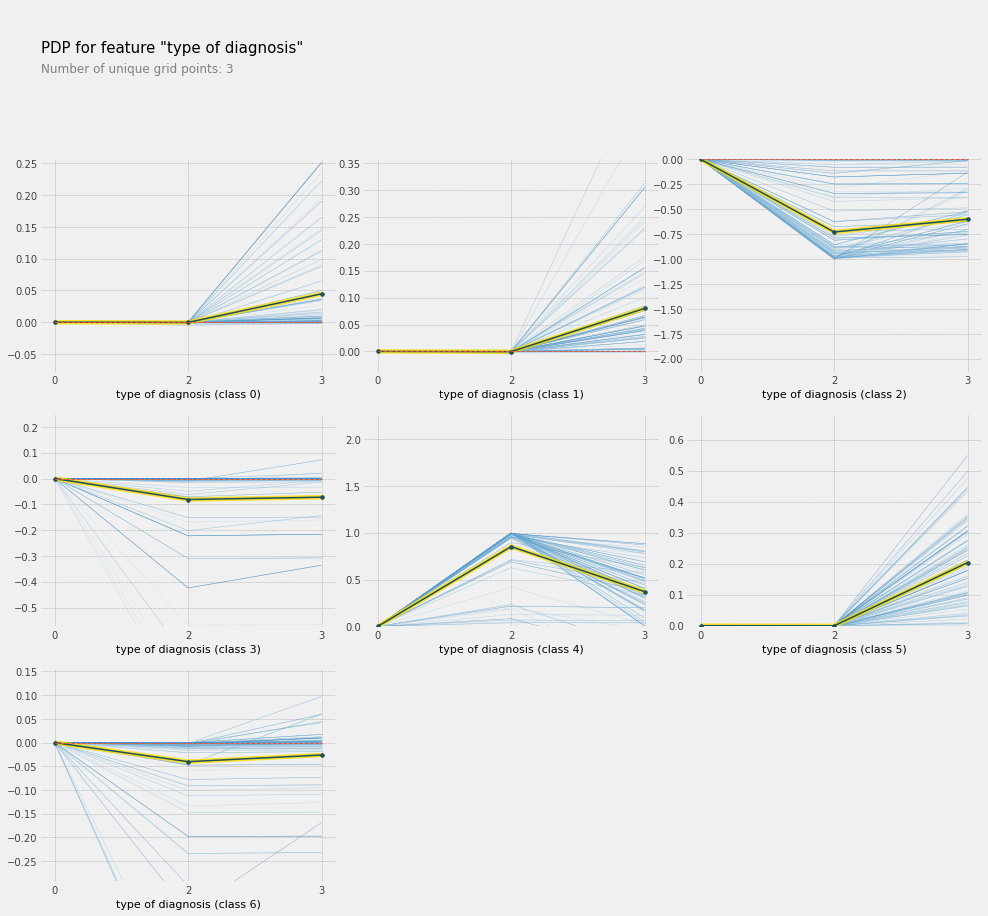

In [85]:
pdp_feat_67_rf = pdp.pdp_isolate(model=xgb_model,
                                 dataset=X_train,
                                 model_features=features,
                                 feature='dx_type_onehot')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_feat_67_rf,
                         feature_name='type of diagnosis',
                         center=True,
                         x_quantile=True,
                         ncols=3,
                         plot_lines=True,
                         frac_to_plot=100)

The PDP (Partial Dependence Plot) shows us the relation between an increase/decrease of one feature to the prediction of the model. 

For example:
In figure 1 (class 0), we observe that the chances of the skin disease belonging to class 0 increases when the value of dx_type_onehot changes from 2 (follow up) to 3 (histopathology).

Similarly, in figure 5 (class 4), we observe that the probability of the skin disease belonging to class 4 is extremely high when the value of dx_type_onehot lies between 0 and 2, and decreases comparatively when it lies between 2 and 3.

Similarly, probability of the skin disease belonging to class 6 is extremely low when the value of dx_type_onehot lies between 0 and 2 (confocal, consensus and follow up), and increases comparatively when it changes from 2 to 3.